# Explaining Hypothesis Tests

This notebook shows how to explain hypothesis tests with general SHAP values.

In this example, we draw an artificial sample of people with diabetes. We then ask why our model believes the diabetic risk level of the population from which our sample was drawn is likely to exceed some threshold $T$.

We find that the variables which most convince our model that the selected population's average risk level exceeds the threshold are body mass index (BMI) and a medical test (S5).

This question is a specific example of a general question. Suppose we are interested in a hypothesis $h$ about a population statistic $\theta$. Given a sample of observations $X$, we can ask why our model believes $h$ is more likely to be true of the population from which our sample was drawn than of the population from which the background data were drawn.

Here, the population statistic $\theta$ is the mean risk level, and the hypothesis $h$ is that $\theta$ exceeds the threshold $T$.

In [1]:
import gshap
from gshap.hypothesis import HypothesisTest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

import random

np.random.seed(0)
random.seed(0)

THRESHOLD = 155

We begin by loading the diabetes dataset and training our regressor.

In [2]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = Lasso(alpha=.1)
reg.fit(X_train, y_train)
print('Test score: %.4f' % reg.score(X_test, y_test))

Test score: 0.3550


Next, we plot the the training samples along BMI and S5. Samples in red have a risk level above the threshold, increasing the probability of confirming our hypothesis. Samples in blue have a risk level below the threshold, increasing the probability of disconfirming our hypothesis.

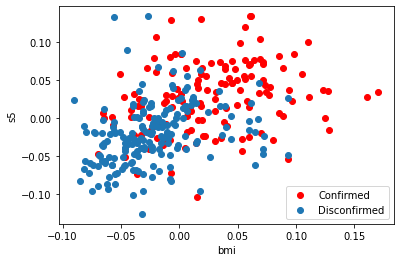

In [3]:
h_conf = y_train > THRESHOLD
X_train_conf = X_train[h_conf]
X_train_dconf = X_train[np.logical_not(h_conf)]

plt.scatter(X_train_conf[:,2], X_train_conf[:,8], c='red', label='Confirmed')
plt.scatter(X_train_dconf[:,2], X_train_dconf[:,8], label='Disconfirmed')
plt.xlabel(diabetes.feature_names[2])
plt.ylabel(diabetes.feature_names[8])
plt.legend()
plt.show()

Compute the G-SHAP values, where $g$ is a `HypothesisTest`. A `HypothesisTest` uses bootstrapping to approximate the probability that the population statistic satisfies our hypothesis for a sample output.

Here, the population statistic is the mean risk level, and the hypothesis is confirmed when the mean risk level exceeds the threshold.

In [4]:
test = lambda y_pred: y_pred.mean() > THRESHOLD
g = HypothesisTest(test, bootstrap_samples=100)
explainer = gshap.KernelExplainer(reg.predict, X_train, g)
x = X_test[y_test > 70] # artifically select a sample which with higher-than-average risk
gshap_values = explainer.gshap_values(x, nsamples=100)

For interpretation, we compare our sample to the background dataset in terms of $g$. We see that the hypothesis is more likely to be true of the population from which our sample was drawn than of the population from which our background data were drawn.

The sum of the G-SHAP values should approximately equal the difference between our sample and the background data (allowing for sampling error).

In [5]:
g_comparison, g_background = explainer.compare(x, bootstrap_samples=10000)
print('Probability that the statistic satisfies our hypothesis in our sample: %.4f' % g_comparison)
print('Probability that the statistic satisifes our hypothesis in the background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Probability that the statistic satisfies our hypothesis in our sample: 0.9300
Probability that the statistic satisifes our hypothesis in the background data: 0.3474
Sum of G-SHAP values: 0.5467


Finally, we plot our results. This plot tells us which features most convince our model the average diabetic risk level in the population from which our sample was drawn exceeds the threshold.

More precisely, our model believes that the mean risk level in the populatioon from which our sample $x$ was drawn exceeds the threshold with probability $p_s$, and that the mean risk level of the population from which our background data were drawn exceeds the threshold with probability $p_b$. Each G-SHAP value $\phi_j$ is the number of percentage points of this difference $p_s-p_b$ explained by feature $j$.

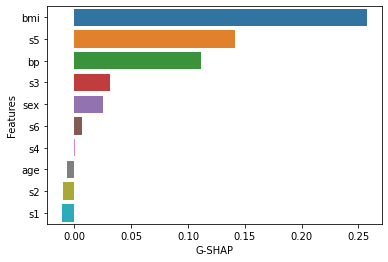

In [6]:
df = pd.DataFrame({
    'Features': list(diabetes.feature_names),
    'G-SHAP': list(gshap_values)
}).sort_values('G-SHAP', ascending=False)
sns.barplot(x='G-SHAP', y='Features', data=df)
plt.show()